===== Verstappen Dominance 2021–2025 =====
Total Races: 114
Total Wins: 59
Total Poles: 48
Wins from Pole: 37
Pole Conversion Rate: 77.1%
Average Lap 1 Position Change (from pole): 0.40


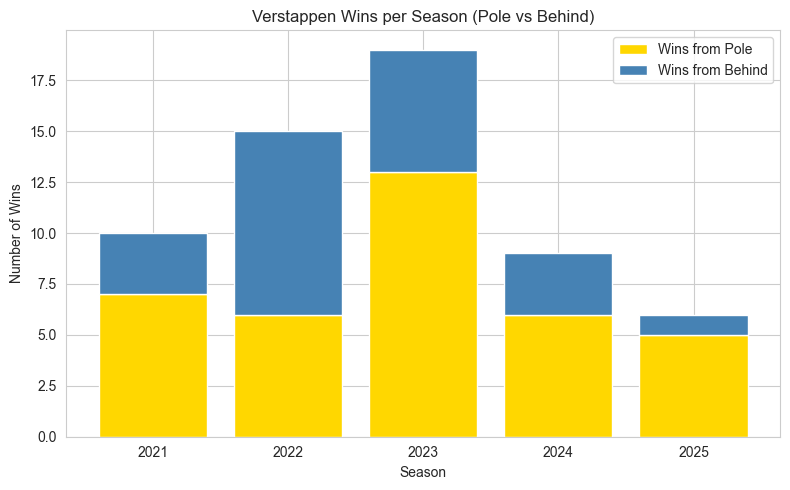

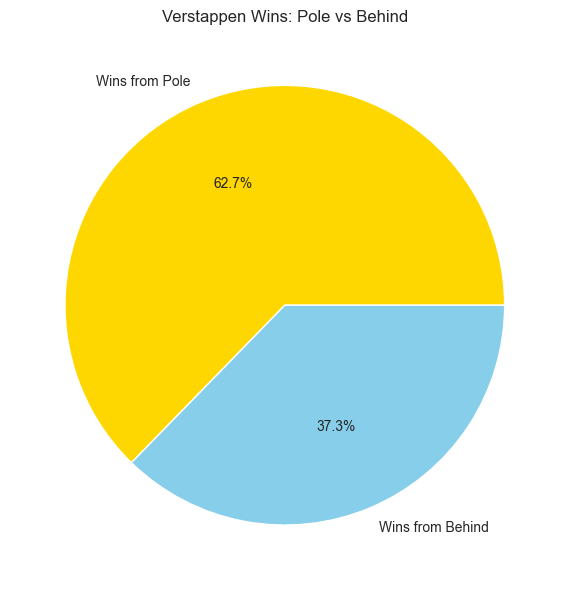

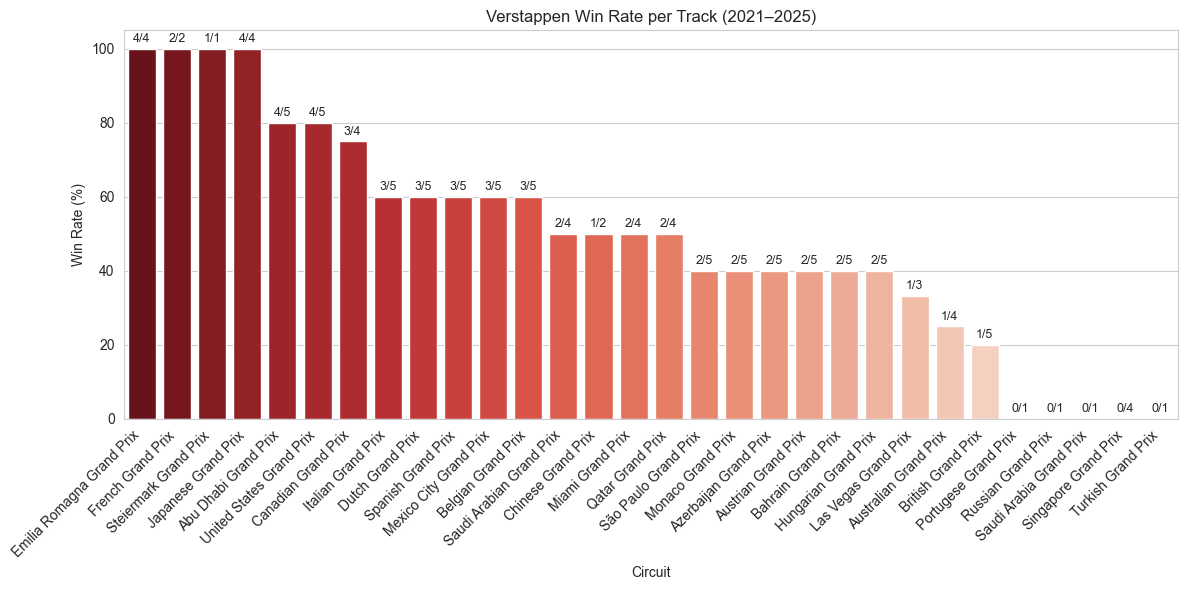

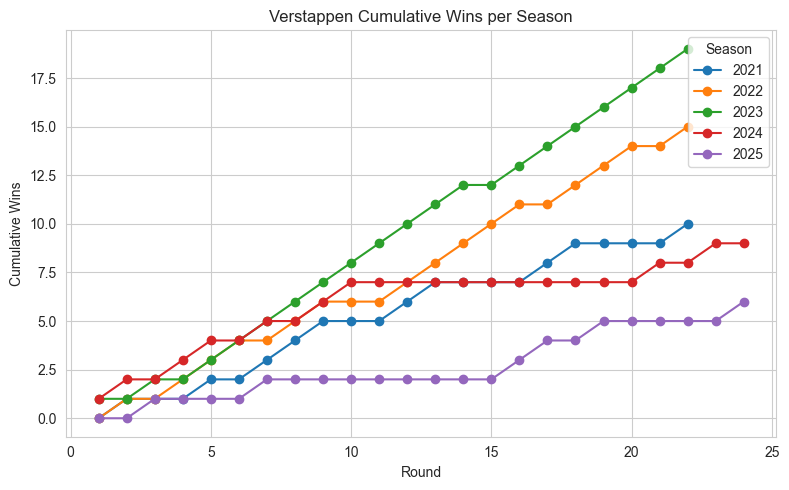

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create graphs directory and set plot style
os.makedirs('../graphs', exist_ok=True)
sns.set_style('whitegrid')

# Load race data for each season and combine into one DataFrame
seasons = [2021, 2022, 2023, 2024, 2025]
dfs = []

for year in seasons:
    file_path = f'../data/processed/poles_{year}.csv'
    df = pd.read_csv(file_path)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# Convert relevant columns to proper data types
df_all['PoleFinishPosition'] = pd.to_numeric(df_all['PoleFinishPosition'], errors='coerce')
df_all['Lap1Position'] = pd.to_numeric(df_all['Lap1Position'], errors='coerce')
df_all['WonFromPole'] = df_all['WonFromPole'].astype(bool)

# Calculate overall Verstappen performance metrics
total_races = len(df_all)
verstappen_wins = (df_all['RaceWinner'] == 'VER').sum()
verstappen_poles = (df_all['PoleDriver'] == 'VER').sum()
wins_from_pole = ((df_all['PoleDriver'] == 'VER') & (df_all['WonFromPole'])).sum()
pole_conversion_rate = wins_from_pole / verstappen_poles * 100 if verstappen_poles > 0 else 0

# Calculate Lap 1 position change for Verstappen pole starts
verstappen_pole_starts = df_all[df_all['PoleDriver']=='VER'].copy()
verstappen_pole_starts['Lap1Change'] = verstappen_pole_starts['PoleFinishPosition'] - verstappen_pole_starts['Lap1Position']
avg_lap1_change = verstappen_pole_starts['Lap1Change'].mean()

# Display overall dominance summary
print("===== Verstappen Dominance 2021–2025 =====")
print(f"Total Races: {total_races}")
print(f"Total Wins: {verstappen_wins}")
print(f"Total Poles: {verstappen_poles}")
print(f"Wins from Pole: {wins_from_pole}")
print(f"Pole Conversion Rate: {pole_conversion_rate:.1f}%")
print(f"Average Lap 1 Position Change (from pole): {avg_lap1_change:.2f}")

# Compute Verstappen win rate per circuit
track_stats = df_all.groupby('Circuit').agg(
    TotalRaces=('RaceWinner', 'count'),
    VerstappenWins=('RaceWinner', lambda x: (x=='VER').sum())
).reset_index()

track_stats['WinRate'] = (track_stats['VerstappenWins'] / track_stats['TotalRaces'] * 100).round(1)
track_stats = track_stats.sort_values('WinRate', ascending=False).reset_index(drop=True)

# Calculate total win rate across all tracks
total_win_rate = track_stats['VerstappenWins'].sum() / track_stats['TotalRaces'].sum() * 100

# Create helper columns for seasonal win breakdown
df_all['VerstappenWin'] = (df_all['RaceWinner'] == 'VER')
df_all['WinFromPole'] = (df_all['VerstappenWin']) & (df_all['WonFromPole'])
df_all['WinFromBehind'] = (df_all['VerstappenWin']) & (~df_all['WonFromPole'])

# Aggregate wins per season by starting position
season_wins = df_all.groupby('Season').agg(
    WinsFromPole=('WinFromPole', 'sum'),
    WinsFromBehind=('WinFromBehind', 'sum')
)

# Plot stacked bars for wins per season
plt.figure(figsize=(8,5))
plt.bar(season_wins.index, season_wins['WinsFromPole'], label='Wins from Pole', color='gold')
plt.bar(
    season_wins.index,
    season_wins['WinsFromBehind'],
    bottom=season_wins['WinsFromPole'],
    label='Wins from Behind',
    color='steelblue'
)

plt.title("Verstappen Wins per Season (Pole vs Behind)")
plt.xlabel("Season")
plt.ylabel("Number of Wins")
plt.legend()
plt.tight_layout()
plt.savefig("../graphs/verstappen_wins_per_season_pole_vs_behind.png")
plt.show()

# Plot overall win distribution from pole vs behind
plt.figure(figsize=(6,6))
plt.pie(
    [wins_from_pole, verstappen_wins - wins_from_pole],
    labels=['Wins from Pole', 'Wins from Behind'],
    autopct='%1.1f%%',
    colors=['gold','skyblue']
)
plt.title("Verstappen Wins: Pole vs Behind")
plt.tight_layout()
plt.savefig("../graphs/verstappen_wins_pole_vs_behind.png")
plt.show()

# Plot track-wise win rate with race counts
plt.figure(figsize=(12,6))
ax = sns.barplot(
    x='Circuit',
    y='WinRate',
    hue='Circuit',
    data=track_stats,
    palette='Reds_r',
    legend=False
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Win Rate (%)")
plt.title("Verstappen Win Rate per Track (2021–2025)")

for i, row in track_stats.iterrows():
    ax.text(i, row['WinRate'] + 1, f"{row['VerstappenWins']}/{row['TotalRaces']}",
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("../graphs/verstappen_winrate_per_track_final.png")
plt.show()

# Plot cumulative wins per season
df_all['VerstappenWin'] = (df_all['RaceWinner'] == 'VER').astype(int)

plt.figure(figsize=(8,5))
for season in seasons:
    season_df = df_all[df_all['Season'] == season].copy()
    season_df['CumWins'] = season_df['VerstappenWin'].cumsum()
    plt.plot(season_df['Round'], season_df['CumWins'], marker='o', label=str(season))

plt.title("Verstappen Cumulative Wins per Season")
plt.xlabel("Round")
plt.ylabel("Cumulative Wins")
plt.legend(title="Season")
plt.grid(True)
plt.tight_layout()
plt.show()
